In [1]:
import gc
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from datetime import date, timedelta
import keras
import time
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
neurons = 512                 
activation_function = 'tanh'  
loss = 'mse'                  
optimizer="adam"              
dropout = 0.25                 
batch_size = 12               
epochs = 53                   
window_len = 7               
training_size = 0.8
merge_date = '2016-01-01'

In [4]:
def get_market_data(market, tag=True):
    market_data = pd.read_html("https://coinmarketcap.com/currencies/" + market + 
                                 "/historical-data/?start=20130428&end="+time.strftime("%Y%m%d"), flavor='html5lib')[0]
    market_data = market_data.assign(Date=pd.to_datetime(market_data['Date']))  
    market_data['Volume'] = (pd.to_numeric(market_data['Volume'], errors='coerce').fillna(0))
    if tag:
        market_data.columns = [market_data.columns[0]] + [tag + '_' + i for i in market_data.columns[1:]]
    return market_data

In [5]:
btc_data = get_market_data("bitcoin", tag='BTC')
btc_data.head()

Date  BTC_Open*  BTC_High  BTC_Low  BTC_Close**    BTC_Volume  \
0 2018-11-14    6351.24   6371.55  5544.09      5738.35  7.398940e+09   
1 2018-11-13    6373.19   6395.27  6342.67      6359.49  4.503800e+09   
2 2018-11-12    6411.76   6434.21  6360.47      6371.27  4.295770e+09   
3 2018-11-11    6413.63   6423.25  6350.17      6411.27  3.939060e+09   
4 2018-11-10    6386.13   6437.28  6385.31      6409.22  3.705320e+09   

   BTC_Market Cap  
0     99712077259  
1    110494466204  
2    110689666528  
3    111373453740  
4    111326145314

In [5]:
btc_data.rename(columns={'BTC_Open*': 'BTC_Open', 'BTC_Close**':'BTC_Close'}, inplace=True)
btc_data.head()

Date  BTC_Open  BTC_High  BTC_Low  BTC_Close    BTC_Volume  \
0 2018-11-14   6351.24   6371.55  5544.09    5738.35  7.398940e+09   
1 2018-11-13   6373.19   6395.27  6342.67    6359.49  4.503800e+09   
2 2018-11-12   6411.76   6434.21  6360.47    6371.27  4.295770e+09   
3 2018-11-11   6413.63   6423.25  6350.17    6411.27  3.939060e+09   
4 2018-11-10   6386.13   6437.28  6385.31    6409.22  3.705320e+09   

   BTC_Market Cap  
0     99712077259  
1    110494466204  
2    110689666528  
3    111373453740  
4    111326145314

In [7]:
def merge_data(a, b, from_date=merge_date):
    """
    a: first DataFrame
    b: second DataFrame
    from_date: includes the data from the provided date and drops the any data before that date.
    returns merged data as Pandas DataFrame
    """
    merged_data = pd.merge(a, b, on=['Date'])
    merged_data = merged_data[merged_data['Date'] >= from_date]
    return merged_data


def add_volatility(data, coins=['BTC', 'ETH']):
    """
    data: input data, pandas DataFrame
    coins: default is for 'btc and 'eth'. It could be changed as needed
    This function calculates the volatility and close_off_high of each given coin in 24 hours, 
    and adds the result as new columns to the DataFrame.
    Return: DataFrame with added columns
    """
    for coin in coins:
    # calculate the daily change
        kwargs = {coin + '_change': lambda x: (x[coin + '_Close'] - x[coin + '_Open']) / x[coin + '_Open'],
                 coin + '_close_off_high': lambda x: 2*(x[coin + '_High'] - x[coin + '_Close']) / (x[coin + '_High'] - x[coin + '_Low']) - 1,
                 coin + '_volatility': lambda x: (x[coin + '_High'] - x[coin + '_Low']) / (x[coin + '_Open'])}
        data = data.assign(**kwargs)
    return data


def create_model_data(data):
    """
    data: pandas DataFrame
    This function drops unnecessary columns and reverses the order of DataFrame based on decending dates.
    Return: pandas DataFrame
    """
    #data = data[['Date']+[coin+metric for coin in ['btc_', 'eth_'] for metric in ['Close','Volume','close_off_high','volatility']]]
    data = data[['Date']+[coin+metric for coin in ['BTC_', 'ETH_'] for metric in ['Close','Volume']]]
    data = data.sort_values(by='Date')
    return data


def split_data(data, training_size=0.8):
    """
    data: Pandas Dataframe
    training_size: proportion of the data to be used for training
    This function splits the data into training_set and test_set based on the given training_size
    Return: train_set and test_set as pandas DataFrame
    """
    return data[:int(training_size*len(data))], data[int(training_size*len(data)):]


def create_inputs(data, coins=['BTC', 'ETH'], window_len=window_len):
    """
    data: pandas DataFrame, this could be either training_set or test_set
    coins: coin datas which will be used as the input. Default is 'btc', 'eth'
    window_len: is an intiger to be used as the look back window for creating a single input sample.
    This function will create input array X from the given dataset and will normalize 'Close' and 'Volume' between 0 and 1
    Return: X, the input for our model as a python list which later needs to be converted to numpy array.
    """
    norm_cols = [coin + metric for coin in coins for metric in ['_Close', '_Volume']]
    inputs = []
    for i in range(len(data) - window_len):
        temp_set = data[i:(i + window_len)].copy()
        inputs.append(temp_set)
    for col in norm_cols:
        inputs[i].loc[:, col] = inputs[i].loc[:, col] / inputs[i].loc[:, col].iloc[0] - 1  
    return inputs


def create_outputs(data, coin, window_len=window_len):
    """
    data: pandas DataFrame, this could be either training_set or test_set
    coin: the target coin in which we need to create the output labels for
    window_len: is an intiger to be used as the look back window for creating a single input sample.
    This function will create the labels array for our training and validation and normalize it between 0 and 1
    Return: Normalized numpy array for 'Close' prices of the given coin
    """
    return (data[coin + '_Close'][window_len:].values / data[coin + '_Close'][:-window_len].values) - 1


def to_array(data):
    """
    data: DataFrame
    This function will convert list of inputs to a numpy array
    Return: numpy array
    """
    x = [np.array(data[i]) for i in range (len(data))]
    return np.array(x)

In [7]:
def show_plot(data, tag):
    fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[3, 1]})
    ax1.set_ylabel('Closing Price ($)',fontsize=12)
    ax2.set_ylabel('Volume ($ bn)',fontsize=12)
    ax2.set_yticks([int('%d000000000'%i) for i in range(10)])
    ax2.set_yticklabels(range(10))
    ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
    ax1.set_xticklabels('')
    ax2.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
    ax2.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2019) for j in [1,7]])
    ax1.plot(data['Date'].astype(datetime.datetime),data[tag +'_Open'])
    ax2.bar(data['Date'].astype(datetime.datetime).values, data[tag +'_Volume'].values)
    fig.tight_layout()
    plt.show()
  

def date_labels():
    last_date = market_data.iloc[0, 0]
    date_list = [last_date - datetime.timedelta(days=x) for x in range(len(X_test))]
    return[date.strftime('%m/%d/%Y') for date in date_list][::-1]


def plot_results(history, model, Y_target, coin):
    plt.figure(figsize=(25, 20))
    plt.subplot(311)
    plt.plot(history.epoch, history.history['loss'], )
    plt.plot(history.epoch, history.history['val_loss'])
    plt.xlabel('Number of Epochs')
    plt.ylabel('Loss')
    plt.title(coin + ' Model Loss')
    plt.legend(['Training', 'Test'])

    plt.subplot(312)
    plt.plot(Y_target)
    plt.plot(model.predict(X_train))
    plt.xlabel('Dates')
    plt.ylabel('Price')
    plt.title(coin + ' Single Point Price Prediction on Training Set')
    plt.legend(['Actual','Predicted'])

    ax1 = plt.subplot(313)
    plt.plot(test_set[coin + '_Close'][window_len:].values.tolist())
    plt.plot(((np.transpose(model.predict(X_test)) + 1) * test_set[coin + '_Close'].values[:-window_len])[0])
    plt.xlabel('Dates')
    plt.ylabel('Price')
    plt.title(coin + ' Single Point Price Prediction on Test Set')
    plt.legend(['Actual','Predicted'])

    date_list = date_labels()
    ax1.set_xticks([x for x in range(len(date_list))])
    for label in ax1.set_xticklabels([date for date in date_list], rotation='vertical')[::2]:
        label.set_visible(False)

    plt.show()

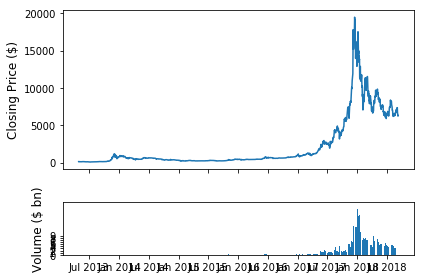

In [13]:
show_plot(btc_data, tag='BTC')

In [9]:
eth_data = get_market_data("ethereum", tag='ETH')
eth_data.head()

Date  ETH_Open*  ETH_High  ETH_Low  ETH_Close**  ETH_Volume  \
0 2018-11-14     206.53    207.04   174.08       181.40  2595330000   
1 2018-11-13     210.15    210.51   206.13       206.83  1610260000   
2 2018-11-12     211.51    212.62   208.92       210.42  1452380000   
3 2018-11-11     212.48    213.00   208.87       211.34  1501600000   
4 2018-11-10     209.97    213.86   209.81       212.53  1377760000   

   ETH_Market Cap  
0     18721032761  
1     21341261802  
2     21707637540  
3     21798464881  
4     21917195708

In [10]:
eth_data.rename(columns={'ETH_Open*': 'ETH_Open', 'ETH_Close**':'ETH_Close'}, inplace=True)
eth_data.head()

Date  ETH_Open  ETH_High  ETH_Low  ETH_Close  ETH_Volume  \
0 2018-11-14    206.53    207.04   174.08     181.40  2595330000   
1 2018-11-13    210.15    210.51   206.13     206.83  1610260000   
2 2018-11-12    211.51    212.62   208.92     210.42  1452380000   
3 2018-11-11    212.48    213.00   208.87     211.34  1501600000   
4 2018-11-10    209.97    213.86   209.81     212.53  1377760000   

   ETH_Market Cap  
0     18721032761  
1     21341261802  
2     21707637540  
3     21798464881  
4     21917195708

In [12]:
data = merge_data(btc_data, eth_data)

In [13]:
data = add_volatility(data)

KeyError: 'BTC_Close'

In [16]:
data = create_model_data(data)

In [ ]:
data

In [14]:
train_set, test_set = split_data(data)
train_set = train_set.drop('Date', 1)
test_set = test_set.drop('Date', 1)

X_train = create_inputs(train_set)
Y_train_btc = create_outputs(train_set, coin='BTC')
X_test = create_inputs(test_set)
Y_test_btc = create_outputs(test_set, coin='BTC')

Y_train_eth = create_outputs(train_set, coin='ETH')
Y_test_eth = create_outputs(test_set, coin='ETH')


In [15]:

X_train, X_test = to_array(X_train), to_array(X_test)

In [16]:
X_test

array([[[ 6.54490000e+02,  6.57590000e+02,  6.54490000e+02, ...,
         -1.07858243e-02, -4.00000000e-01,  3.85208012e-02],
        [ 6.51630000e+02,  6.57460000e+02,  6.48450000e+02, ...,
          7.63485477e-02, -5.37414966e-01,  1.21991701e-01],
        [ 6.54230000e+02,  6.56220000e+02,  6.45880000e+02, ...,
         -1.32416787e-01,  7.54716981e-01,  1.53400868e-01],
        ...,
        [ 6.55410000e+02,  6.63110000e+02,  6.52790000e+02, ...,
         -1.08391608e-01,  5.94339623e-01,  1.48251748e-01],
        [ 6.50730000e+02,  6.56370000e+02,  6.48520000e+02, ...,
         -2.52215406e-02,  4.11764706e-01,  5.79413770e-02],
        [ 6.64920000e+02,  6.66580000e+02,  6.46720000e+02, ...,
          1.57977883e-01, -8.67841410e-01,  1.79304897e-01]],

       [[ 6.51630000e+02,  6.57460000e+02,  6.48450000e+02, ...,
          7.63485477e-02, -5.37414966e-01,  1.21991701e-01],
        [ 6.54230000e+02,  6.56220000e+02,  6.45880000e+02, ...,
         -1.32416787e-01,  7.54716981e

In [13]:
def build_model(inputs, output_size, neurons, activ_func=activation_function, dropout=dropout, loss=loss, optimizer=optimizer):
    """
    inputs: input data as numpy array
    output_size: number of predictions per input sample
    neurons: number of neurons/ units in the LSTM layer
    active_func: Activation function to be used in LSTM layers and Dense layer
    dropout: dropout ration, default is 0.25
    loss: loss function for calculating the gradient
    optimizer: type of optimizer to backpropagate the gradient
    This function will build 3 layered RNN model with LSTM cells with dripouts after each LSTM layer 
    and finally a dense layer to produce the output using keras' sequential model.
    Return: Keras sequential model and model summary
    """
    model = Sequential()
    model.add(LSTM(neurons, return_sequences=True, input_shape=(inputs.shape[1], inputs.shape[2]), activation=activ_func))
    model.add(Dropout(dropout))
    model.add(LSTM(neurons, return_sequences=True, activation=activ_func))
    model.add(Dropout(dropout))
    model.add(LSTM(neurons, activation=activ_func))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer, metrics=['mae'])
    model.summary()
    return model

In [14]:
# clean up the memory
gc.collect()

# random seed for reproducibility
np.random.seed(202)

# initialise model architecture
btc_model = build_model(X_train, output_size=1, neurons=neurons)

# train model on data
btc_history = btc_model.fit(X_train, Y_train_btc, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_test, Y_test_btc), shuffle=False)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 7, 512)            1058816   
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 512)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 7, 512)            2099200   
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 512)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
__________